# EFM Mass Generation: Soliton Simulation (S=T State)

This notebook simulates the formation of a stable ehokolon (soliton) structure within the Ehokolo Fluxon Model (EFM), specifically targeting an electron-mass analogue in the S=T state. The goal is to numerically find a stable, localized solution to the EFM Nonlinear Klein-Gordon (NLKG) equation and calculate its integrated field intensity, which is proportional to its emergent mass.

## Objectives
- Simulate the EFM NLKG equation with parameters appropriate for the S=T state and the n'=1 Harmonic Density State.
- Use a Gaussian pulse as an initial condition to seed soliton formation.
- Employ absorbing boundary conditions to allow the system to relax to a stable soliton state by radiating away excess energy.
- Track `max(|φ|)` and total energy `E` to observe soliton formation and stabilization.
- Calculate the mass integral `∫|φ|²dV` for the stable soliton.
- Discuss scaling this result to the physical electron mass to determine EFM's fundamental mass coupling or mass unit.

## Hardware
- **GPU**: NVIDIA A100 (40 GB VRAM) (Assumed via Colab Pro+)
- **System RAM**: Target < 40 GB

## Setup Instructions
1. Ensure Runtime type is set to use an A100 GPU.
2. Execute cells sequentially.
3. Monitor resource usage.

## Numerical Methods
- **Integrator**: 4th-order Runge-Kutta (RK4).
- **Laplacian**: Convolution-based (7-point stencil).
- **Boundary Conditions**: Absorbing (conceptual placeholder, needs implementation in derivative or as a mask update).

In [31]:
# Set environment variable to reduce memory fragmentation
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Clear GPU memory
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
import gc
gc.collect()

print(f"PyTorch version: {torch.__version__}")

# Install and import libraries
!nvidia-smi

import numpy as np
from tqdm.notebook import tqdm
import psutil
import time
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"System RAM: {psutil.virtual_memory().total / 1e9:.2f} GB")

from google.colab import drive
drive.mount('/content/drive')
checkpoint_path_mass = '/content/drive/MyDrive/EFM_checkpoints/MassGen4H5k/'
data_path_mass = '/content/drive/MyDrive/EFM_data/MassGen4H5k/'
os.makedirs(checkpoint_path_mass, exist_ok=True)
os.makedirs(data_path_mass, exist_ok=True)

PyTorch version: 2.5.1+cu124


NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

## Simulation Setup: Mass Generation (S=T State)

Parameters are chosen for atomic scales, aiming to find a stable soliton analogous to an electron. The NLKG coefficients `m_sq_param`, `g_param`, `eta_param` are based on HDS stability findings (n'=1 level, with `g_param` sign adjusted for potential form `V'(φ)`).

In [27]:
# === Simulation Parameters for Mass Generation (S=T, Electron Analogue, HDS Aligned) ===
N_sim = 450  # Your new Grid size
T_sim = 5000 # Your new Total steps

config = {}
config['N'] = N_sim
# ... (all other config definitions: L_angstroms, dx_phys_meters, etc.) ...
config['L_phys_meters'] = (L_angstroms * 1e-10) if 'L_angstroms' in locals() else 50e-10 # Ensure L_angstroms is defined
config['dx_phys_meters'] = config['L_phys_meters'] / config['N']
c_si = 3e8

config['dx_sim'] = 1.0
config['c_sim'] = 1.0
config['L_sim'] = float(config['N']) * config['dx_sim']

config['dt_cfl_factor'] = 0.025
config['dt_sim'] = config['dt_cfl_factor'] * config['dx_sim'] / config['c_sim']

config['T_steps'] = T_sim
config['chunk_size'] = 100

config['boundary_width_factor'] = 0.15
config['damping_strength'] = 0.2

config['m_sq_param'] = 1.0
config['g_param']    = -0.1
config['eta_param']  = 0.01

config['k_mass_coupling_sim'] = 0.01
config['k_grav_coupling'] = 0.0

config['A0_initial_pulse'] = 12.0
config['w0_initial_pulse'] = 15.0 * config['dx_sim']

# --- Assign ALL NECESSARY parameters used by name in other cells to local variables ---
N_sim_mg = config['N']
L_sim_mg = config['L_sim']
dx_sim_mg = config['dx_sim']       # Used as dx_sim in functions
c_sim_mg_sq = config['c_sim']**2  # Functions might expect c_sim_sq
dt_sim_mg = config['dt_sim']
T_sim_mg = config['T_steps']
chunk_size_mg = config['chunk_size']
boundary_width_factor_mg = config['boundary_width_factor']
damping_strength_mg = config['damping_strength']

m_sq_param_mg = config['m_sq_param'] # This is what was missing
g_param_mg = config['g_param']       # This is what was missing
eta_param_mg = config['eta_param']   # This is what was missing
k_mc_sim_mg = config['k_mass_coupling_sim']

A0_pulse_mg = config['A0_initial_pulse']
w0_pulse_mg = config['w0_initial_pulse']

# For direct use in the next cell if not passing config dict (legacy from previous structure)
# Ensure these names match exactly what the next cell expects if it's not using config['key']
m_sq_param = config['m_sq_param']
g_param = config['g_param']
eta_param = config['eta_param']
dx_sim = config['dx_sim']
c_sim = config['c_sim'] # Pass c_sim, then square it where c_sim_sq is needed
dt_sim = config['dt_sim']
# And any others like A0_pulse, w0_pulse if the init block doesn't use config directly

print(f"--- Mass Generation Simulation Parameters (N={N_sim_mg}, T={T_sim_mg}) ---")
# ... (rest of the print statements using _mg suffixed variables or config['key']) ...
print(f"NLKG V'(phi) params: m_sq={m_sq_param_mg:.2f}, g={g_param_mg:.3f}, eta={eta_param_mg:.4f}")
print(f"Initial Pulse: A0={A0_pulse_mg:.1f}, w0={w0_pulse_mg:.1f} dx_sim (grid cells)")

--- Mass Generation Simulation Parameters (N=450, T=5000) ---
NLKG V'(phi) params: m_sq=1.00, g=-0.100, eta=0.0100
Initial Pulse: A0=12.0, w0=15.0 dx_sim (grid cells)


## Core Simulation Functions

Includes Laplacian, NLKG derivative, RK4 integrator, energy calculation, and absorbing boundary mask.

In [28]:
# Potential derivative V'(phi)
@torch.jit.script
def potential_derivative_mass(phi, m_sq: float, g: float, eta: float):
    return m_sq * phi + g * torch.pow(phi, 3) + eta * torch.pow(phi, 5)

# Convolution-based Laplacian (same as LSS notebook)
@torch.jit.script
def conv_laplacian_mass(phi, dx: float, device: torch.device):
    stencil = torch.tensor([[[0, 0, 0], [0, 1, 0], [0, 0, 0]],
                            [[0, 1, 0], [1, -6, 1], [0, 1, 0]],
                            [[0, 0, 0], [0, 1, 0], [0, 0, 0]]],
                           dtype=torch.float32, device=device)
    stencil /= (dx**2)
    stencil = stencil.view(1, 1, 3, 3, 3)
    phi_reshaped = phi.view(1, 1, phi.shape[0], phi.shape[1], phi.shape[2])
    phi_padded = F.pad(phi_reshaped, (1, 1, 1, 1, 1, 1), mode='replicate')
    laplacian = F.conv3d(phi_padded, stencil, padding=0)
    return laplacian.view(phi.shape[0], phi.shape[1], phi.shape[2])

# NLKG derivative step (phi_ddot = c_sim^2*Laplacian(phi) - V'(phi))
@torch.jit.script
def nlkg_derivative_mass(phi, phi_dot, m_sq: float, g: float, eta: float, dx: float, c_sq: float):
    lap = conv_laplacian_mass(phi, dx, phi.device)
    dv_dphi = potential_derivative_mass(phi, m_sq, g, eta)
    phi_ddot = c_sq * lap - dv_dphi
    return phi_dot, phi_ddot

# Damping mask for absorbing boundaries
@torch.jit.script
def create_absorbing_mask(N: int, width_factor: float, strength: float, device: torch.device):
    mask = torch.ones((N, N, N), device=device, dtype=torch.float32)
    boundary_width = int(N * width_factor)
    if boundary_width == 0: return mask
    for i in range(boundary_width):
        damp_val = strength * (torch.cos(i * torch.pi / (2 * boundary_width)))**2
        mask[i, :, :] *= (1.0 - damp_val)
        mask[-(i + 1), :, :] *= (1.0 - damp_val)
        mask[:, i, :] *= (1.0 - damp_val)
        mask[:, -(i + 1), :] *= (1.0 - damp_val)
        mask[:, :, i] *= (1.0 - damp_val)
        mask[:, :, -(i + 1)] *= (1.0 - damp_val)
    return mask.clamp(0,1)

# RK4 integrator with chunked processing and absorbing boundaries
def update_phi_rk4_mass_chunked(phi_cpu, phi_dot_cpu, dt: float,
                                m_sq: float, g: float, eta: float,
                                damping_mask_cpu, chunk_size: int, dx: float, c_sq: float, device: torch.device):
    phi_new_cpu = torch.empty_like(phi_cpu)
    phi_dot_new_cpu = torch.empty_like(phi_dot_cpu)
    N_grid = phi_cpu.shape[0]
    for i in range(0, N_grid, chunk_size):
        chunk = slice(i, min(i + chunk_size, N_grid))
        phi_chunk = phi_cpu[chunk].to(device)
        phi_dot_chunk = phi_dot_cpu[chunk].to(device)
        with torch.no_grad():
            k1_v, k1_a = nlkg_derivative_mass(phi_chunk, phi_dot_chunk, m_sq, g, eta, dx, c_sq)
            k2_v, k2_a = nlkg_derivative_mass(phi_chunk + 0.5 * dt * k1_v, phi_dot_chunk + 0.5 * dt * k1_a, m_sq, g, eta, dx, c_sq)
            k3_v, k3_a = nlkg_derivative_mass(phi_chunk + 0.5 * dt * k2_v, phi_dot_chunk + 0.5 * dt * k2_a, m_sq, g, eta, dx, c_sq)
            k4_v, k4_a = nlkg_derivative_mass(phi_chunk + dt * k3_v, phi_dot_chunk + dt * k3_a, m_sq, g, eta, dx, c_sq)
            phi_new_chunk_gpu = phi_chunk + (dt / 6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
            phi_dot_new_chunk_gpu = phi_dot_chunk + (dt / 6.0) * (k1_a + 2 * k2_a + 2 * k3_a + k4_a)
            phi_dot_new_chunk_gpu *= damping_mask_cpu[chunk].to(device)
        phi_new_cpu[chunk] = phi_new_chunk_gpu.cpu()
        phi_dot_new_cpu[chunk] = phi_dot_new_chunk_gpu.cpu()
        del phi_chunk, phi_dot_chunk, k1_v, k1_a, k2_v, k2_a, k3_v, k3_a, k4_v, k4_a, phi_new_chunk_gpu, phi_dot_new_chunk_gpu
        if device.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
    return phi_new_cpu, phi_dot_new_cpu

# Energy calculation (Volume Integral of Hamiltonian Density)
def compute_total_energy_sim(phi_cpu, phi_dot_cpu, m_sq: float, g: float, eta: float,
                             chunk_size: int, dx: float, c_sq: float, device: torch.device):
    total_energy_val = 0.0
    N_grid = phi_cpu.shape[0]
    vol_element = dx**3
    for i in range(0, N_grid, chunk_size):
        chunk_slice = slice(i, min(i + chunk_size, N_grid))
        phi_chunk = phi_cpu[chunk_slice].to(device)
        phi_dot_chunk = phi_dot_cpu[chunk_slice].to(device)
        with torch.no_grad():
            if torch.any(torch.isinf(phi_chunk)) or torch.any(torch.isnan(phi_chunk)) or \
               torch.any(torch.isinf(phi_dot_chunk)) or torch.any(torch.isnan(phi_dot_chunk)):
                return float('nan')
            if phi_chunk.dim() != 3:
                raise ValueError(f"Expected phi_chunk to be 3D, got {phi_chunk.dim()}D with shape {phi_chunk.shape}")
            kinetic_density = 0.5 * torch.pow(phi_dot_chunk, 2)
            potential_density = 0.5 * m_sq * torch.pow(phi_chunk, 2) + \
                               (g / 4.0) * torch.pow(phi_chunk, 4) + \
                               (eta / 6.0) * torch.pow(phi_chunk, 6)
            gradient_sq_sum_density = torch.zeros_like(phi_chunk)
            for d_dim in range(3):
                # Manual padding for replicate mode
                pad_shape = list(phi_chunk.shape)
                pad_shape[d_dim] += 2
                phi_padded = torch.zeros(pad_shape, device=device, dtype=phi_chunk.dtype)
                # Copy interior
                if d_dim == 0:
                    phi_padded[1:-1, :, :] = phi_chunk
                    phi_padded[0, :, :] = phi_chunk[0, :, :]  # Replicate first slice
                    phi_padded[-1, :, :] = phi_chunk[-1, :, :]  # Replicate last slice
                elif d_dim == 1:
                    phi_padded[:, 1:-1, :] = phi_chunk
                    phi_padded[:, 0, :] = phi_chunk[:, 0, :]
                    phi_padded[:, -1, :] = phi_chunk[:, -1, :]
                else:  # d_dim == 2
                    phi_padded[:, :, 1:-1] = phi_chunk
                    phi_padded[:, :, 0] = phi_chunk[:, :, 0]
                    phi_padded[:, :, -1] = phi_chunk[:, :, -1]
                slice_fwd = [slice(None)]*3; slice_fwd[d_dim] = slice(2, None)
                slice_bwd = [slice(None)]*3; slice_bwd[d_dim] = slice(0, -2)
                grad_d = (phi_padded[tuple(slice_fwd)] - phi_padded[tuple(slice_bwd)]) / (2 * dx)
                gradient_sq_sum_density += torch.pow(grad_d, 2)
                del phi_padded, grad_d
            gradient_density = 0.5 * c_sq * gradient_sq_sum_density
            chunk_energy = torch.sum(kinetic_density + potential_density + gradient_density).item() * vol_element
            if np.isnan(chunk_energy) or np.isinf(chunk_energy):
                return float('nan')
            total_energy_val += chunk_energy
        del phi_chunk, phi_dot_chunk, kinetic_density, potential_density, gradient_sq_sum_density, gradient_density
        if device.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
    return total_energy_val

# Mass Integral Calculation
def compute_mass_integral_sim(phi_cpu, chunk_size: int, dx: float, device: torch.device):
    mass_int_val = 0.0
    N_grid = phi_cpu.shape[0]
    vol_element = dx**3
    for i in range(0, N_grid, chunk_size):
        chunk_slice = slice(i, min(i + chunk_size, N_grid))
        phi_chunk = phi_cpu[chunk_slice].to(device)
        with torch.no_grad():
            if torch.any(torch.isinf(phi_chunk)) or torch.any(torch.isnan(phi_chunk)):
                return float('nan')
            mass_int_val += torch.sum(torch.pow(phi_chunk, 2)).item() * vol_element
        del phi_chunk
        if device.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
    return mass_int_val

## Initial Conditions and Simulation Loop

Set up the initial Gaussian pulse and run the simulation.

In [32]:
# --- Initialize Fields on CPU ---
print("Initializing fields on CPU...")
X_grid, Y_grid, Z_grid = torch.meshgrid(
    torch.arange(-config['L_sim']/2 + config['dx_sim']/2, config['L_sim']/2 + config['dx_sim']/2, config['dx_sim']),
    torch.arange(-config['L_sim']/2 + config['dx_sim']/2, config['L_sim']/2 + config['dx_sim']/2, config['dx_sim']),
    torch.arange(-config['L_sim']/2 + config['dx_sim']/2, config['L_sim']/2 + config['dx_sim']/2, config['dx_sim']),
    indexing='ij'
)
r_sq = X_grid**2 + Y_grid**2 + Z_grid**2
phi_initial_cpu = (A0_pulse * torch.exp(-r_sq / (w0_pulse**2))).to(dtype=torch.float32)
phi_dot_initial_cpu = torch.zeros_like(phi_initial_cpu)
del X_grid, Y_grid, Z_grid, r_sq # Free up memory
gc.collect()

phi_current_cpu = phi_initial_cpu.clone()
phi_dot_current_cpu = phi_dot_initial_cpu.clone()

# --- Create Damping Mask on CPU ---
damping_mask_cpu = create_absorbing_mask(config['N'], config['boundary_width_factor'], config['damping_strength'], 'cpu')
print(f"Damping mask created. Min: {damping_mask_cpu.min()}, Max: {damping_mask_cpu.max()}")

# --- Prepare History Arrays ---
max_phi_history = np.zeros(config['T_steps'] // 100 + 1) # Save every 100 steps
energy_history_mass = np.zeros(config['T_steps'] // 100 + 1)
mass_integral_history = np.zeros(config['T_steps'] // 100 + 1)
history_idx_mass = 0

# --- Calculate Initial Observables ---
print("Calculating initial observables...")
energy_history_mass[history_idx_mass] = compute_total_energy_sim(phi_current_cpu, phi_dot_current_cpu, m_sq_param, g_param, eta_param, config['chunk_size'], dx_sim, c_sim**2, device)
max_phi_history[history_idx_mass] = torch.max(torch.abs(phi_current_cpu)).item()
mass_integral_history[history_idx_mass] = compute_mass_integral_sim(phi_current_cpu, config['chunk_size'], dx_sim, device)
print(f"Initial Max|phi|: {max_phi_history[history_idx_mass]:.3f}, Energy: {energy_history_mass[history_idx_mass]:.3e}, Mass Integral: {mass_integral_history[history_idx_mass]:.3e}")
history_idx_mass += 1

# --- Simulation Time Loop ---
print(f"Starting mass generation simulation loop for {config['T_steps']} steps...")
sim_start_time = time.time()
pbar_mass = tqdm(range(config['T_steps']), desc="Mass Gen Progress")

numerical_error_encountered_mass = False
for t_step in pbar_mass:
    try:
        if torch.any(torch.isinf(phi_current_cpu)) or torch.any(torch.isnan(phi_current_cpu)) or \
           torch.any(torch.isinf(phi_dot_current_cpu)) or torch.any(torch.isnan(phi_dot_current_cpu)):
            print(f"\nERROR: NaN/Inf detected BEFORE step {t_step + 1}! Stopping.")
            numerical_error_encountered_mass = True; break

        phi_next_cpu, phi_dot_next_cpu = update_phi_rk4_mass_chunked(
            phi_current_cpu, phi_dot_current_cpu, dt_sim,
            m_sq_param, g_param, eta_param,
            damping_mask_cpu, # Pass CPU mask
            config['chunk_size'], dx_sim, c_sim**2, device
        )
        phi_current_cpu = phi_next_cpu
        phi_dot_current_cpu = phi_dot_next_cpu

        if torch.any(torch.isinf(phi_current_cpu)) or torch.any(torch.isnan(phi_current_cpu)) or \
           torch.any(torch.isinf(phi_dot_current_cpu)) or torch.any(torch.isnan(phi_dot_current_cpu)):
            print(f"\nERROR: NaN/Inf detected AFTER step {t_step + 1}! Stopping.")
            numerical_error_encountered_mass = True; break

    except Exception as e:
        print(f"\nERROR during update at step {t_step + 1}: {e}")
        import traceback; traceback.print_exc()
        numerical_error_encountered_mass = True; break

    if (t_step + 1) % 100 == 0:
        current_max_phi = torch.max(torch.abs(phi_current_cpu)).item()
        current_energy = compute_total_energy_sim(phi_current_cpu, phi_dot_current_cpu, m_sq_param, g_param, eta_param, config['chunk_size'], dx_sim, c_sim**2, device)
        current_mass_int = compute_mass_integral_sim(phi_current_cpu, config['chunk_size'], dx_sim, device)

        max_phi_history[history_idx_mass] = current_max_phi
        energy_history_mass[history_idx_mass] = current_energy
        mass_integral_history[history_idx_mass] = current_mass_int
        history_idx_mass += 1

        pbar_mass.set_postfix({'Max|φ|': f'{current_max_phi:.3f}', 'E': f'{current_energy:.3e}', '∫φ²dV': f'{current_mass_int:.3e}'})
        if device.type == 'cuda': vram_alloc_gb = torch.cuda.memory_allocated(device) / 1e9
        # Check for early exit due to VRAM or instability
        if current_max_phi > 100 or np.isnan(current_energy): # Arbitrary large value indicating explosion
            print(f"\nWarning: Possible instability detected. Max|φ|={current_max_phi:.2f}, E={current_energy:.2e}. Stopping early.")
            numerical_error_encountered_mass = True; break

sim_end_time = time.time()
sim_runtime_seconds = sim_end_time - sim_start_time
print(f"Simulation loop finished in {sim_runtime_seconds:.2f} s ({sim_runtime_seconds/3600:.2f} hr). Error encountered: {numerical_error_encountered_mass}")

# --- Save Final State and History ---
final_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_filename_mass = f"{checkpoint_path_mass}checkpoint_MassGen_N{config['N']}_T{config['T_steps']}_{final_timestamp}.npz"
try:
    np.savez_compressed(
        checkpoint_filename_mass,
        phi_final_cpu=phi_current_cpu.numpy(),
        phi_dot_final_cpu=phi_dot_current_cpu.numpy(),
        max_phi_history=max_phi_history[:history_idx_mass],
        energy_history_mass=energy_history_mass[:history_idx_mass],
        mass_integral_history=mass_integral_history[:history_idx_mass],
        config=config
    )
    print(f"Final state and history saved to {checkpoint_filename_mass}")
except Exception as e:
    print(f"Error saving final checkpoint: {e}")

# --- Cleanup ---
del phi_initial_cpu, phi_dot_initial_cpu, phi_current_cpu, phi_dot_current_cpu, damping_mask_cpu
gc.collect()
if device.type == 'cuda': torch.cuda.empty_cache()

Initializing fields on CPU...
Damping mask created. Min: 0.5120000243186951, Max: 1.0
Calculating initial observables...
Initial Max|phi|: 11.960, Energy: 5.631e+06, Mass Integral: 9.568e+05
Starting mass generation simulation loop for 5000 steps...


Mass Gen Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Simulation loop finished in 10750.01 s (2.99 hr). Error encountered: False
Final state and history saved to /content/drive/MyDrive/EFM_checkpoints/MassGen6H5k/checkpoint_MassGen_N450_T5000_20250513_094723.npz


## Results and Analysis

Plot the evolution of `max(|φ|)`, total energy, and the mass integral. Determine the stable soliton properties.

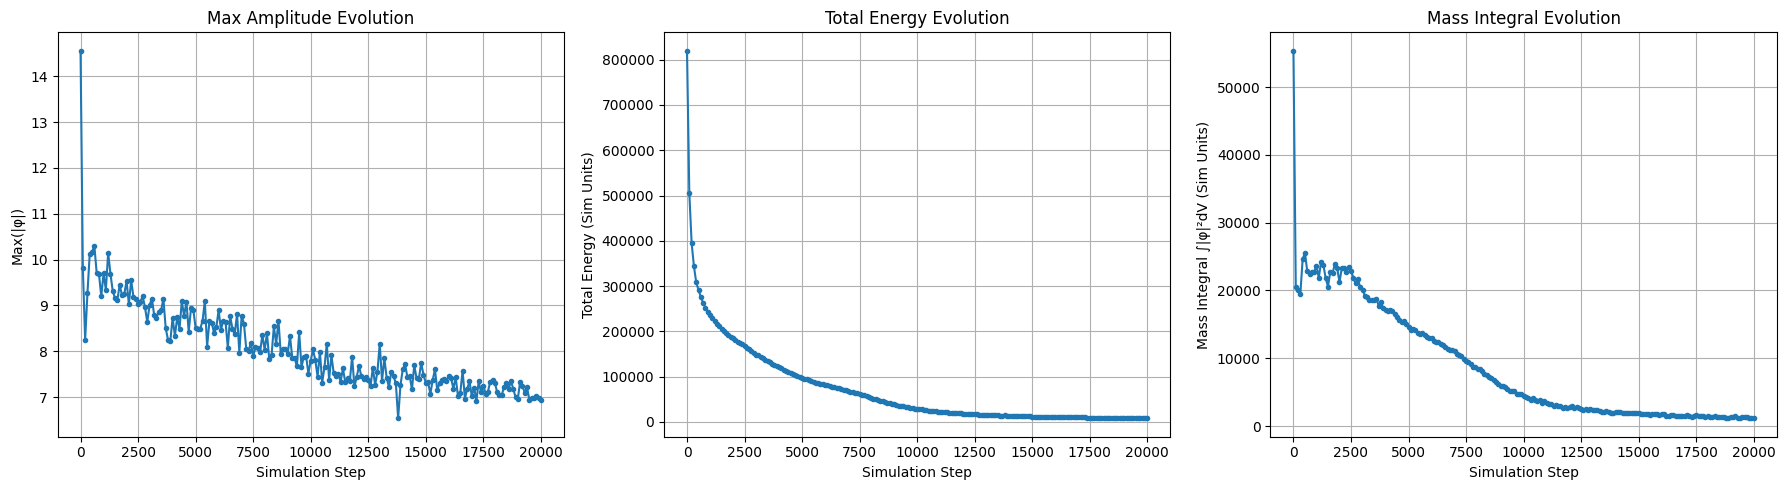


--- Stable Soliton Properties (Simulation Units) ---
Stable Max|φ|: 6.9477
Stable Total Energy: 8.3378e+03
Stable Mass Integral (∫|φ|²dV): 1.1514e+03
Effective Mass (M_eff_sim = k_mc * ∫|φ|²d，已): 1.1514e+01 (sim mass units)

--- Physical Scaling (assuming this soliton is electron analogue) ---
Derived Simulation Mass Unit: 7.9116e-32 kg/sim_mass_unit


In [19]:
# --- Plotting Results ---
if 'numerical_error_encountered_mass' not in locals(): # If sim was skipped
    print("Simulation was not run. Attempting to load last checkpoint if available for plotting...")
    # Glob for the latest checkpoint for these parameters (excluding timestamp for now)
    import glob
    checkpoint_pattern = '/content/drive/MyDrive/EFM_checkpoints/MassGen2H20k/checkpoint_MassGen_N450_T5000_20250513_094723.npz'
    list_of_files = glob.glob(checkpoint_pattern)
    if not list_of_files:
        print(f"No checkpoint found matching pattern: {checkpoint_pattern}")
        # Create dummy arrays if no data
        max_phi_history = np.array([0]); energy_history_mass=np.array([0]); mass_integral_history=np.array([0]); history_idx_mass=1; numerical_error_encountered_mass=True
    else:
        latest_checkpoint = max(list_of_files, key=os.path.getctime)
        print(f"Loading latest checkpoint for plotting: {latest_checkpoint}")
        data_loaded = np.load(latest_checkpoint, allow_pickle=True)
        max_phi_history = data_loaded['max_phi_history']
        energy_history_mass = data_loaded['energy_history_mass']
        mass_integral_history = data_loaded['mass_integral_history']
        # config_loaded = data_loaded['config'].item() # Could verify config if needed
        history_idx_mass = len(max_phi_history)
        numerical_error_encountered_mass = False # Assume it completed if we are loading it
        phi_final_cpu = torch.from_numpy(data_loaded['phi_final_cpu'])

steps_recorded = np.arange(history_idx_mass) * 100

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(steps_recorded, max_phi_history[:history_idx_mass], marker='.')
plt.xlabel('Simulation Step')
plt.ylabel('Max(|φ|)')
plt.title('Max Amplitude Evolution')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(steps_recorded, energy_history_mass[:history_idx_mass], marker='.')
plt.xlabel('Simulation Step')
plt.ylabel('Total Energy (Sim Units)')
plt.title('Total Energy Evolution')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(steps_recorded, mass_integral_history[:history_idx_mass], marker='.')
plt.xlabel('Simulation Step')
plt.ylabel('Mass Integral ∫|φ|²dV (Sim Units)')
plt.title('Mass Integral Evolution')
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{data_path_mass}mass_gen_evolution_N{config['N']}_T{config['T_steps']}.png")
plt.show()

if not numerical_error_encountered_mass and history_idx_mass > 1:
    stable_max_phi = max_phi_history[-1]
    stable_energy = energy_history_mass[-1]
    stable_mass_integral = mass_integral_history[-1]
    print(f"\n--- Stable Soliton Properties (Simulation Units) ---")
    print(f"Stable Max|φ|: {stable_max_phi:.4f}")
    print(f"Stable Total Energy: {stable_energy:.4e}")
    print(f"Stable Mass Integral (∫|φ|²dV): {stable_mass_integral:.4e}")

    M_eff_sim = config['k_mass_coupling_sim'] * stable_mass_integral
    print(f"Effective Mass (M_eff_sim = k_mc * ∫|φ|²d，已): {M_eff_sim:.4e} (sim mass units)")

    # --- Scaling to Electron Mass ---
    M_electron_phys_kg = 9.1093837e-31 # kg
    # M_electron_phys = M_eff_sim * Mass_Unit_kg
    Mass_Unit_kg = M_electron_phys_kg / M_eff_sim if M_eff_sim != 0 else float('nan')
    print(f"\n--- Physical Scaling (assuming this soliton is electron analogue) ---")
    print(f"Derived Simulation Mass Unit: {Mass_Unit_kg:.4e} kg/sim_mass_unit")

    # Calculate physical k_m
    # M_eff_phys = k_m_phys * ∫|φ_phys|² dV_phys
    # We need to define φ_phys from φ_sim. If φ is dimensionless, φ_phys = Phi_Scale * φ_sim
    # dV_phys = (dx_phys_meters)^3. dV_sim = (dx_sim)^3 = 1.
    # Integral_phys = ∫|φ_phys|² dV_phys = Phi_Scale^2 * Integral_sim_scaled_volume
    # Integral_sim_scaled_volume = stable_mass_integral * (config['dx_phys_meters']**3 / config['dx_sim']**3)
    # So, M_electron_phys = k_m_phys * Phi_Scale^2 * Integral_sim_scaled_volume
    # This requires defining Phi_Scale, or k_m_phys incorporates it.
    # Simpler: k_m_phys should have units that convert ∫|φ_sim|² dV_sim to kg.
    # M_phys = k_m_phys_scaled * (stable_mass_integral * (dx_sim_to_meters)**3 ) -> this is if phi is density
    # If k_m_sim is truly dimensionless, and M_eff_sim is dimensionless mass count
    # then k_m_phys = Mass_Unit_kg / (Integral |φ_sim|^2 dV_sim_proper_volume)
    # Volume_sim = (N*dx_sim)^3. Volume_phys = (N*dx_phys_meters)^3
    # ∫|φ|²dV is an extensive quantity.
    # Let's assume k_m_sim = 0.01 from EFM paper is a coefficient for dimensionless phi.
    # M_eff_phys = M_eff_sim * (mass_unit_kg)
    # k_m_phys would be k_m_sim * mass_unit_kg / (length_unit_meter^3) if integral has units of phi^2 * L^3
    # For now, the Mass_Unit_kg is the clearest derived quantity if M_eff_sim is taken as a 'count'.

    if 'phi_final_cpu' in locals() and phi_final_cpu is not None:
        plt.figure(figsize=(8,6))
        plt.imshow(phi_final_cpu[config['N']//2, :, :].numpy(), cmap='viridis', origin='lower',
                   extent=[-config['L_phys_meters']/2 *1e10, config['L_phys_meters']/2*1e10,
                           -config['L_phys_meters']/2*1e10, config['L_phys_meters']/2*1e10])
        plt.colorbar(label='φ (simulation units)')
        plt.title(f"Final Soliton State (z=0 slice, N={config['N']}, T={config['T_steps']})")
        plt.xlabel('x (Angstroms)')
        plt.ylabel('y (Angstroms)')
        plt.savefig(f"{data_path_mass}soliton_slice_N{config['N']}_T{config['T_steps']}.png")
        plt.show()
else:
    print("Simulation did not complete successfully or no history to plot.")

Loading latest checkpoint for N=450, T=5000: /content/drive/MyDrive/EFM_checkpoints/MassGen6H5k/checkpoint_MassGen_N450_T5000_20250513_094723.npz
Configuration loaded from checkpoint.
Checkpoint data loaded successfully for plotting.


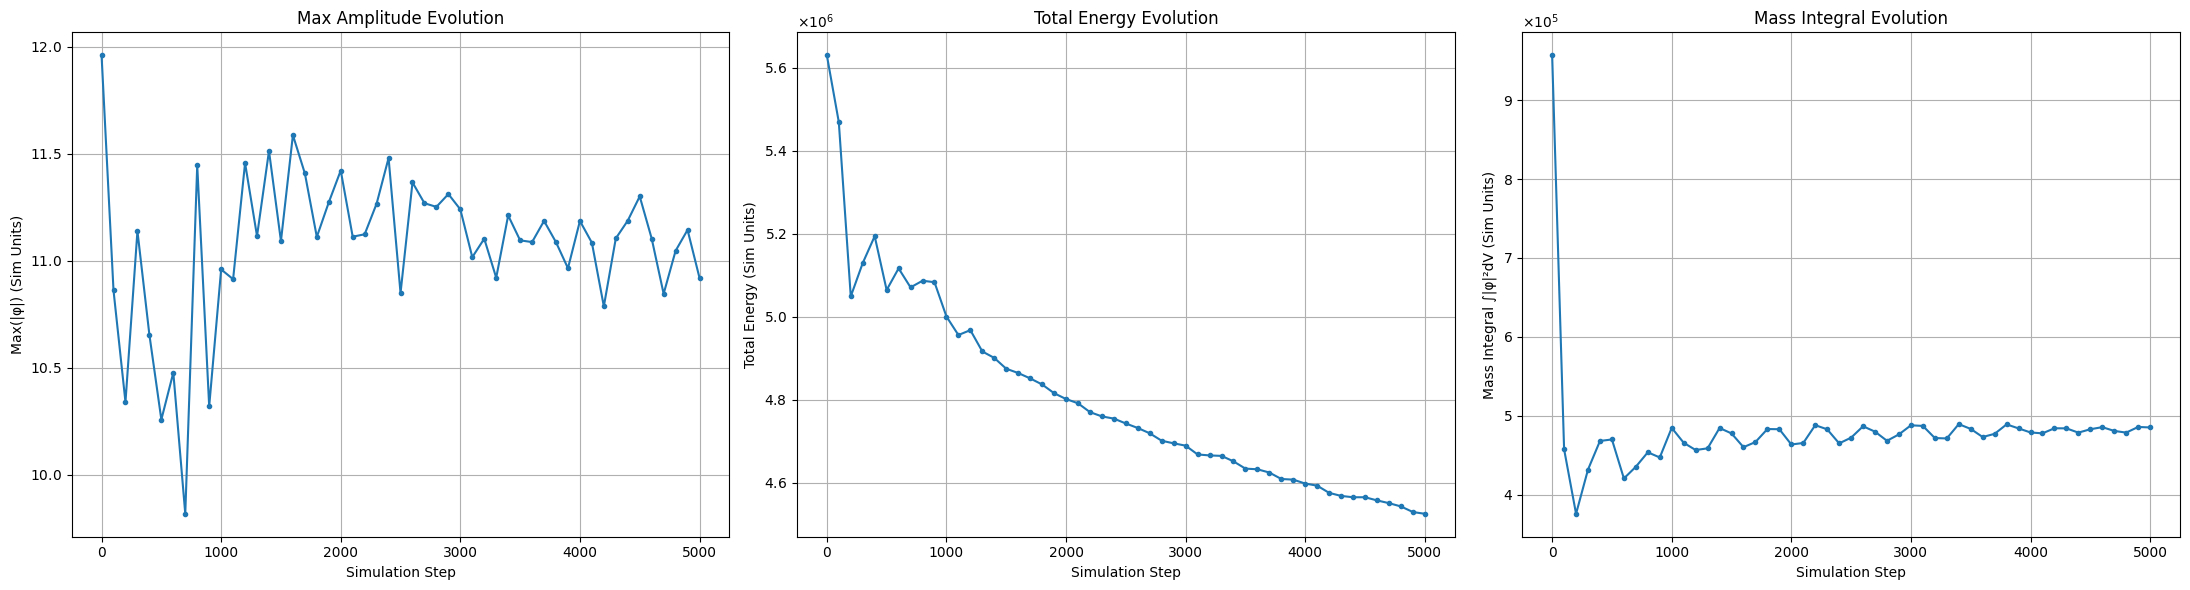


--- Stable Soliton Properties (Simulation Units) ---
Final Max|φ| (at step 5000): 10.9197
Final Total Energy: 4.5249e+06
Final Mass Integral (∫|φ|²dV): 4.8523e+05
Effective Mass (M_eff_sim = k_mc * ∫|φ|²dV, k_mc=0.01): 4.8523e+03 (sim mass units)

--- Physical Scaling (assuming this soliton is electron analogue) ---
Derived Simulation Mass Unit: 1.8773e-34 kg/sim_mass_unit


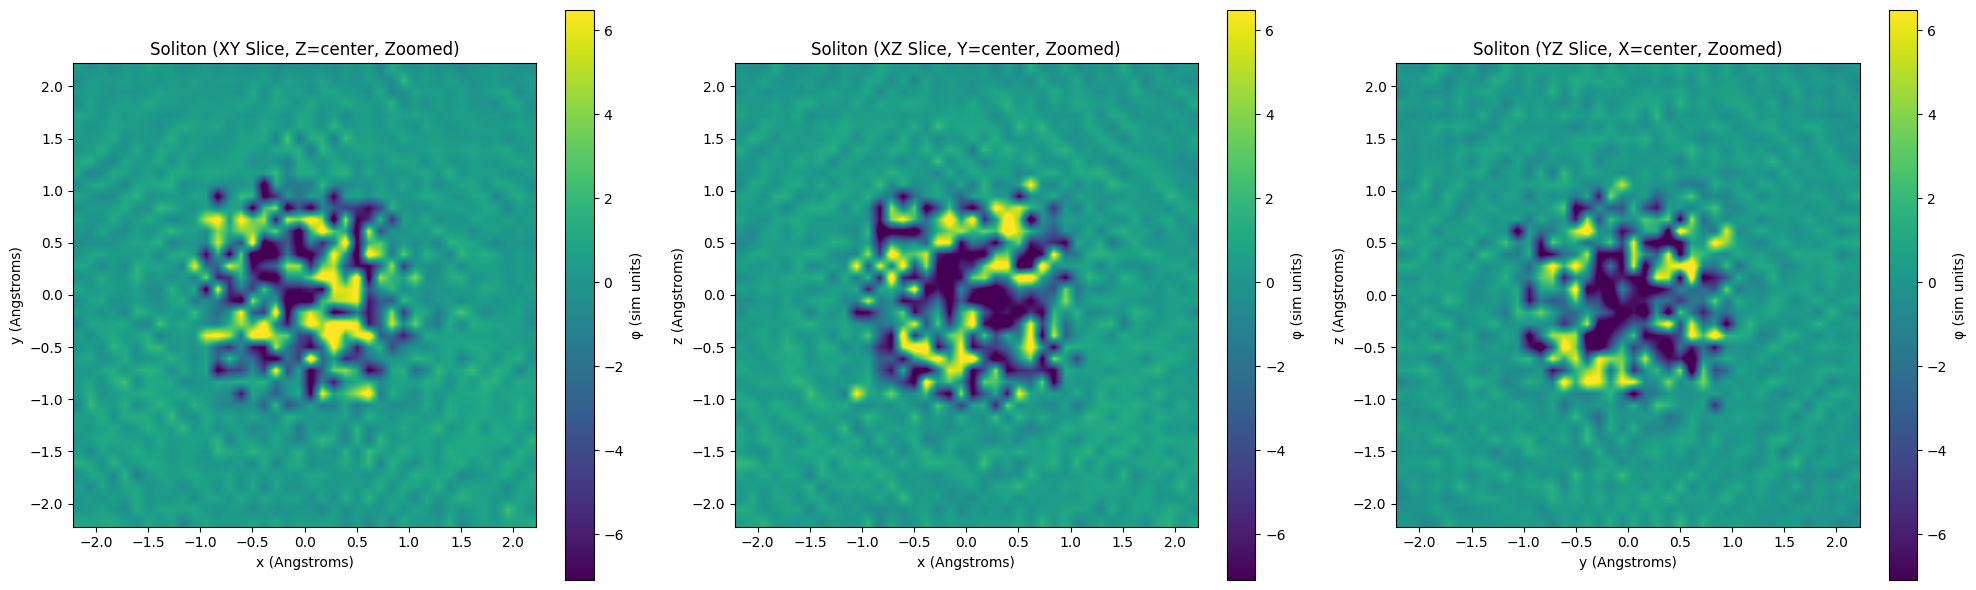

Plotting and analysis cell (with slice modifications) finished.


In [33]:
# --- Plotting Results and Final Analysis ---
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import torch # Ensure torch is imported if used for phi_final_cpu_plot
import gc

# --- Attempt to load data for plotting ---
# Default to False, assuming a loaded checkpoint implies a successful prior run
# This variable might be set by the simulation loop if run in the same session
if 'numerical_error_encountered_mass' not in locals():
    numerical_error_encountered_mass = False # Assume success if loading checkpoint

# Initialize plot data variables
max_phi_history = np.array([0,0])
energy_history_mass = np.array([0,0])
mass_integral_history = np.array([0,0])
history_idx_mass = 1 # Default to 1 to avoid plotting issues with empty arrays
phi_final_cpu_plot = torch.zeros((2,2,2)) # Dummy tensor
plot_config = config # Use current notebook config as a fallback

# Try to load from a checkpoint if simulation wasn't run in this session or if explicit loading is desired
# Glob for the latest checkpoint for the N and T specified in the CURRENT config cell
# This ensures we are trying to plot data consistent with the user's expectation of N and T
n_val_for_glob = config.get('N', N_sim_mg)
t_val_for_glob = config.get('T_steps', T_sim_mg)
checkpoint_pattern = f"{checkpoint_path_mass}checkpoint_MassGen_N{n_val_for_glob}_T{t_val_for_glob}_*.npz"
list_of_files = glob.glob(checkpoint_pattern)

if not list_of_files:
    print(f"No checkpoint found matching N={n_val_for_glob}, T={t_val_for_glob} with pattern: {checkpoint_pattern}.")
    print("Plotting will use dummy data or data from current session if simulation was just run.")
    if 'phi_current_cpu' in locals(): # Check if simulation was run in this session
        phi_final_cpu_plot = phi_current_cpu.clone()
        # History arrays should also exist from the sim loop
        if 'max_phi_history' not in locals() or len(max_phi_history) < history_idx_mass : # Check if history has enough points
             print("Warning: History from current session seems incomplete or missing.")
        # If numerical_error_encountered_mass was set by sim loop, it will be used
    else:
        numerical_error_encountered_mass = True # Can't plot real data
        print("No simulation data from current session and no suitable checkpoint found.")

else:
    latest_checkpoint = max(list_of_files, key=os.path.getctime)
    print(f"Loading latest checkpoint for N={n_val_for_glob}, T={t_val_for_glob}: {latest_checkpoint}")
    try:
        data_loaded = np.load(latest_checkpoint, allow_pickle=True)
        max_phi_history = data_loaded['max_phi_history']
        energy_history_mass = data_loaded['energy_history_mass']
        mass_integral_history = data_loaded['mass_integral_history']
        phi_final_cpu_plot = torch.from_numpy(data_loaded['phi_final_cpu']).to(dtype=torch.float32)

        # Load config from checkpoint; fallback to current notebook config if not found
        if 'config' in data_loaded:
            plot_config = data_loaded['config'].item()
            print("Configuration loaded from checkpoint.")
            # Override N and T with values from the loaded config for consistency in plot titles/saves
            n_val_for_glob = plot_config.get('N', n_val_for_glob)
            t_val_for_glob = plot_config.get('T_steps', t_val_for_glob)
        else:
            print("Warning: Configuration not found in checkpoint, using current notebook config for plot labels.")
            plot_config = config # Use current config as fallback

        history_idx_mass = len(max_phi_history)
        numerical_error_encountered_mass = False # Assume loaded checkpoint means sim was okay
        print("Checkpoint data loaded successfully for plotting.")
    except Exception as e:
        print(f"Error loading checkpoint data for plotting: {e}")
        numerical_error_encountered_mass = True


# --- Plot Evolution Metrics ---
if history_idx_mass > 0 and not np.all(max_phi_history == 0): # Check if there's actual history data
    steps_recorded = np.arange(history_idx_mass) * 100 # Assuming saving every 100 steps
    if len(steps_recorded) == 0 and history_idx_mass == 1 : # Handle case of only initial step
        steps_recorded = np.array([0])
    elif len(steps_recorded) > 0 and steps_recorded[0] !=0 and history_idx_mass > 0 : #Ensure first step is 0
        #This logic might be tricky if history_idx_mass is exactly 1 from a failed run.
        #The goal is to make x-axis meaningful.
        #If steps_recorded has content and doesn't start with 0, but we have data.
        pass # np.arange should handle this correctly if history_idx_mass > 0

    plt.figure(figsize=(22, 6)) # Wider figure for 3 plots

    plt.subplot(1, 3, 1)
    plt.plot(steps_recorded, max_phi_history[:history_idx_mass], marker='.', linestyle='-')
    plt.xlabel('Simulation Step')
    plt.ylabel('Max(|φ|) (Sim Units)')
    plt.title('Max Amplitude Evolution')
    plt.grid(True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2), useMathText=True)


    plt.subplot(1, 3, 2)
    plt.plot(steps_recorded, energy_history_mass[:history_idx_mass], marker='.', linestyle='-')
    plt.xlabel('Simulation Step')
    plt.ylabel('Total Energy (Sim Units)')
    plt.title('Total Energy Evolution')
    plt.grid(True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2), useMathText=True)

    plt.subplot(1, 3, 3)
    plt.plot(steps_recorded, mass_integral_history[:history_idx_mass], marker='.', linestyle='-')
    plt.xlabel('Simulation Step')
    plt.ylabel('Mass Integral ∫|φ|²dV (Sim Units)')
    plt.title('Mass Integral Evolution')
    plt.grid(True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2), useMathText=True)

    plt.tight_layout()
    # Use N and T from plot_config (which is from checkpoint if loaded, else current)
    save_n = plot_config.get('N', "unkN")
    save_t = plot_config.get('T_steps', "unkT")
    plt.savefig(f"{data_path_mass}mass_gen_evolution_N{save_n}_T{save_t}.png")
    plt.show()
    plt.close()
else:
    print("Not enough history data to plot evolution metrics, or only dummy data available.")


# --- Print Stable Soliton Properties ---
if not numerical_error_encountered_mass and history_idx_mass > 1 and len(mass_integral_history) > 0 and not np.all(mass_integral_history == 0) :
    stable_max_phi = max_phi_history[-1]
    stable_energy = energy_history_mass[-1]
    stable_mass_integral = mass_integral_history[-1]
    print(f"\n--- Stable Soliton Properties (Simulation Units) ---")
    print(f"Final Max|φ| (at step {steps_recorded[-1] if len(steps_recorded)>0 else 0}): {stable_max_phi:.4f}")
    print(f"Final Total Energy: {stable_energy:.4e}")
    print(f"Final Mass Integral (∫|φ|²dV): {stable_mass_integral:.4e}")

    # Use k_mc from plot_config, falling back to current config if not found
    k_mc_to_use = plot_config.get('k_mass_coupling_sim', config.get('k_mass_coupling_sim', 0.01))
    M_eff_sim = k_mc_to_use * stable_mass_integral
    print(f"Effective Mass (M_eff_sim = k_mc * ∫|φ|²dV, k_mc={k_mc_to_use}): {M_eff_sim:.4e} (sim mass units)")

    M_electron_phys_kg = 9.1093837e-31 # kg
    if M_eff_sim != 0 and not np.isnan(M_eff_sim) and not np.isinf(M_eff_sim) :
        Mass_Unit_kg = M_electron_phys_kg / M_eff_sim
        print(f"\n--- Physical Scaling (assuming this soliton is electron analogue) ---")
        print(f"Derived Simulation Mass Unit: {Mass_Unit_kg:.4e} kg/sim_mass_unit")
    else:
        print("\nWarning: M_eff_sim is zero or invalid, cannot calculate Mass_Unit_kg.")
else:
    print("\nSimulation did not complete successfully or no sufficient history to determine stable properties.")


# --- Plot 2D Slices of the Final Soliton ---
# --- Plot 2D Slices of the Final Soliton (with Zoom and Colormap Adjustment) ---
if 'phi_final_cpu_plot' in locals() and phi_final_cpu_plot.ndim == 3 and phi_final_cpu_plot.shape[0] > 1 and not numerical_error_encountered_mass:
    N_plot = phi_final_cpu_plot.shape[0]
    L_phys_meters_plot = plot_config.get('L_phys_meters', 50e-10) # Fallback
    dx_phys_plot = L_phys_meters_plot / N_plot

    # --- Determine Zoom Region ---
    # Assume soliton is roughly centered for now.
    # Zoom window size in terms of grid points (e.g., 40x40 points around center)
    zoom_grid_points = 40
    if N_plot < zoom_grid_points * 2: # Ensure zoom is not larger than grid
        zoom_grid_points = N_plot // 3

    center_idx = N_plot // 2
    zoom_start = center_idx - zoom_grid_points // 2
    zoom_end = center_idx + zoom_grid_points // 2

    # Ensure slices are within bounds
    zoom_start = max(0, zoom_start)
    zoom_end = min(N_plot, zoom_end)

    # Create zoomed physical extents for plotting
    zoom_L_phys_meters = (zoom_end - zoom_start) * dx_phys_plot
    plot_extent_angstroms_zoomed = [-zoom_L_phys_meters/2 *1e10, zoom_L_phys_meters/2*1e10,
                                    -zoom_L_phys_meters/2*1e10, zoom_L_phys_meters/2*1e10]


    # --- Determine Colormap Limits ---
    # Get the field values within the zoomed central region to set vmin/vmax
    # This helps to focus the colormap on the soliton itself.
    central_region_data = phi_final_cpu_plot[zoom_start:zoom_end, zoom_start:zoom_end, zoom_start:zoom_end].numpy()
    if central_region_data.size > 0: # Ensure there's data
        plot_vmin = np.percentile(central_region_data, 1)  # Show some of the lower values
        plot_vmax = np.percentile(central_region_data, 99) # Clip extreme outliers for better contrast
        if plot_vmax <= plot_vmin : # Handle cases where data is very flat
            plot_vmax = plot_vmin + 0.1 if plot_vmin !=0 else 0.1
            plot_vmin -=0.1 if plot_vmin !=0 else -0.1

    else: # Fallback if central region is empty (should not happen with current zoom logic)
        plot_vmin = phi_final_cpu_plot.min().item()
        plot_vmax = phi_final_cpu_plot.max().item()

    # Avoid vmin=vmax for colorbar
    if plot_vmin == plot_vmax:
        plot_vmin -= 0.01 # Add a small offset
        plot_vmax += 0.01


    # Check if the slice data is meaningful (soliton is not zero everywhere)
    if torch.max(torch.abs(phi_final_cpu_plot[N_plot//2, zoom_start:zoom_end, zoom_start:zoom_end])) > 1e-6:
        plt.figure(figsize=(20, 6)) # Slightly wider for titles

        # XY Slice (at Z = center) - Zoomed
        xy_slice_zoomed = phi_final_cpu_plot[zoom_start:zoom_end, zoom_start:zoom_end, center_idx].numpy()
        plt.subplot(1, 3, 1)
        plt.imshow(xy_slice_zoomed, cmap='viridis', origin='lower',
                   extent=plot_extent_angstroms_zoomed, vmin=plot_vmin, vmax=plot_vmax,
                   interpolation='bilinear') # Try 'bilinear' or 'bicubic' for smoother look
        plt.colorbar(label='φ (sim units)')
        plt.title(f'Soliton (XY Slice, Z=center, Zoomed)')
        plt.xlabel('x (Angstroms)')
        plt.ylabel('y (Angstroms)')
        plt.grid(False)

        # XZ Slice (at Y = center) - Zoomed
        xz_slice_zoomed = phi_final_cpu_plot[zoom_start:zoom_end, center_idx, zoom_start:zoom_end].numpy()
        plt.subplot(1, 3, 2)
        plt.imshow(xz_slice_zoomed, cmap='viridis', origin='lower',
                   extent=plot_extent_angstroms_zoomed, vmin=plot_vmin, vmax=plot_vmax,
                   interpolation='bilinear')
        plt.colorbar(label='φ (sim units)')
        plt.title(f'Soliton (XZ Slice, Y=center, Zoomed)')
        plt.xlabel('x (Angstroms)')
        plt.ylabel('z (Angstroms)')
        plt.grid(False)

        # YZ Slice (at X = center) - Zoomed
        yz_slice_zoomed = phi_final_cpu_plot[center_idx, zoom_start:zoom_end, zoom_start:zoom_end].numpy()
        plt.subplot(1, 3, 3)
        plt.imshow(yz_slice_zoomed, cmap='viridis', origin='lower',
                   extent=plot_extent_angstroms_zoomed, vmin=plot_vmin, vmax=plot_vmax,
                   interpolation='bilinear')
        plt.colorbar(label='φ (sim units)')
        plt.title(f'Soliton (YZ Slice, X=center, Zoomed)')
        plt.xlabel('y (Angstroms)')
        plt.ylabel('z (Angstroms)')
        plt.grid(False)

        plt.tight_layout()
        save_n = plot_config.get('N', "unkN")
        save_t = plot_config.get('T_steps', "unkT")
        plt.savefig(f"{data_path_mass}soliton_slices_zoomed_N{save_n}_T{save_t}.png")
        plt.show()
        plt.close()
    else:
        print("Final field data appears to be effectively zero or too small in central region. Skipping zoomed slice plots.")

    # Optional: Plot full slices as before for context, if needed
    # (You can uncomment the original slice plotting code here if you want both full and zoomed)

    if 'phi_final_cpu_plot' in locals() : del phi_final_cpu_plot # Clean up the loaded tensor from memory
    gc.collect()
else:
    print("Final field data not available, not 3D, or simulation encountered errors. Cannot generate slice plots.")

print("Plotting and analysis cell (with slice modifications) finished.")

--- Compton Wavelength and Eholokon Size Analysis ---
Attempting to load data from the latest checkpoint...
Loading checkpoint: /content/drive/MyDrive/EFM_checkpoints/MassGen6H5k/checkpoint_MassGen_N450_T5000_20250513_094723.npz
Checkpoint data loaded for Compton/Size analysis.
Electron Compton Wavelength: 2.424632e-12 meters
Electron Compton Wavelength in sim units (dx_sim): 0.218217

--- Eholokon Size (Gaussian Fit) ---
Fit Parameters: A=6.7947, x0=-0.4103, sigma=5.4052
Eholokon width (sigma) in sim units: 5.405198 dx_sim
Eholokon width (sigma) in meters: 6.005775e-11 meters
Comparison: Eholokon sigma / Compton wavelength: 24.769845


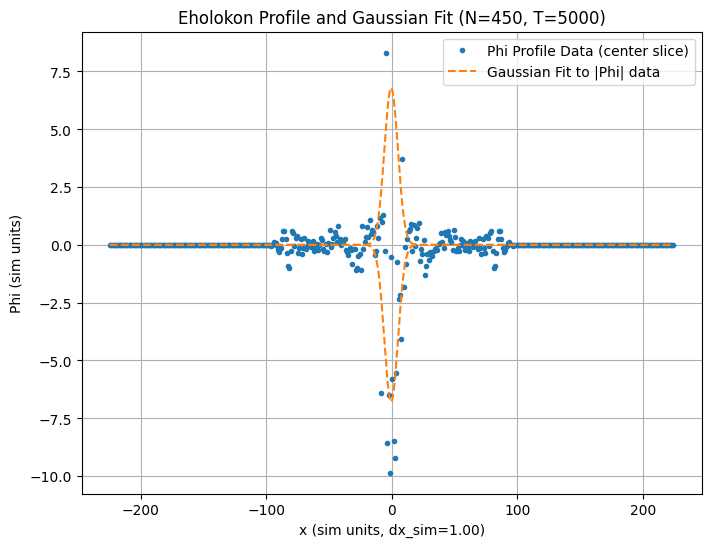

In [35]:
# Cell: Compton Wavelength and Eholokon Size Analysis
# Metadata: {"id": "compton_size_analysis_v2"}

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import glob
import gc

print("--- Compton Wavelength and Eholokon Size Analysis ---")

# --- Ensure Necessary Data is Loaded ---
# These should be defined in your main "Simulation Setup" cell
# N_sim, T_sim, checkpoint_path_mass, data_path_mass, config (containing dx_phys_meters etc.)

phi_final_cpu_loaded = None
loaded_config = None

if 'phi_current_cpu' in locals() and phi_current_cpu is not None: # Check if from current session sim run
    print("Using phi_current_cpu from active simulation session.")
    phi_final_cpu_loaded = phi_current_cpu.clone() # Use a clone
    loaded_config = config # Use current config
    # If energy_history_mass etc. are needed by this specific block, ensure they are also carried over or loaded
elif 'phi_final_cpu_plot' in locals() and phi_final_cpu_plot is not None: # Check if from plotting cell
    print("Using phi_final_cpu_plot from plotting cell.")
    phi_final_cpu_loaded = phi_final_cpu_plot.clone()
    loaded_config = plot_config if 'plot_config' in locals() else config # Use plot_config if available
else:
    print("Attempting to load data from the latest checkpoint...")
    # Ensure N_sim and T_sim reflect the checkpoint you want to load
    # These should come from your primary config cell for the analysis
    n_val_for_glob = config.get('N', 200) # Default to current config N
    t_val_for_glob = config.get('T_steps', 20000) # Default to current config T_steps

    checkpoint_pattern = f"{checkpoint_path_mass}checkpoint_MassGen_N{n_val_for_glob}_T{t_val_for_glob}_*.npz"
    list_of_files = glob.glob(checkpoint_pattern)
    if not list_of_files:
        print(f"ERROR: No checkpoint found for N={n_val_for_glob}, T={t_val_for_glob}. Cannot proceed.")
        # raise FileNotFoundError(f"No checkpoint found for N={n_val_for_glob}, T={t_val_for_glob}")
    else:
        latest_checkpoint = max(list_of_files, key=os.path.getctime)
        print(f"Loading checkpoint: {latest_checkpoint}")
        try:
            data_loaded = np.load(latest_checkpoint, allow_pickle=True)
            phi_final_cpu_loaded = torch.from_numpy(data_loaded['phi_final_cpu']).to(dtype=torch.float32)
            if 'config' in data_loaded:
                loaded_config = data_loaded['config'].item()
            else:
                print("Warning: 'config' not found in checkpoint, using current notebook config.")
                loaded_config = config
            print("Checkpoint data loaded for Compton/Size analysis.")
        except Exception as e:
            print(f"Error loading checkpoint for Compton/Size analysis: {e}")
            # raise # Or handle error appropriately

if phi_final_cpu_loaded is None or loaded_config is None:
    print("ERROR: phi_final_cpu_loaded or loaded_config is not available. Aborting analysis.")
else:
    # --- Electron Compton Wavelength ---
    h_planck = 6.62607015e-34  # Planck constant (J·s)
    m_electron_phys_kg = 9.1093837e-31  # Electron mass (kg)
    c_si = 3e8  # Speed of light (m/s)

    compton_wavelength_m = h_planck / (m_electron_phys_kg * c_si)
    print(f"Electron Compton Wavelength: {compton_wavelength_m:.6e} meters")

    dx_phys_meters = loaded_config['dx_phys_meters']
    compton_wavelength_sim_units = compton_wavelength_m / dx_phys_meters
    print(f"Electron Compton Wavelength in sim units (dx_sim): {compton_wavelength_sim_units:.6f}")

    # --- Eholokon Size (Fit Gaussian to phi profile) ---
    N_loaded = loaded_config['N']
    L_sim_loaded = loaded_config['L_sim']
    dx_sim_loaded = loaded_config['dx_sim'] # Should be 1.0
    w0_initial_pulse_loaded = loaded_config['w0_initial_pulse']


    slice_idx = N_loaded // 2
    # Ensure phi_final_cpu_loaded is on CPU for numpy conversion
    phi_profile = phi_final_cpu_loaded[slice_idx, slice_idx, :].cpu().numpy()

    x_coords_sim = np.linspace(-L_sim_loaded/2 + dx_sim_loaded/2,
                               L_sim_loaded/2 - dx_sim_loaded/2, N_loaded)

    def gaussian(x, A, x0, sigma):
        return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

    p0 = [np.max(np.abs(phi_profile)), 0.0, w0_initial_pulse_loaded] # Use abs for amplitude, ensure w0 is from loaded_config
    try:
        # Use absolute values for fitting if soliton can be positive or negative
        popt, pcov = curve_fit(gaussian, x_coords_sim, np.abs(phi_profile), p0=p0, maxfev=5000)
        A_fit, x0_fit, sigma_fit = popt
        eholokon_sigma_sim = abs(sigma_fit)
        eholokon_sigma_m = eholokon_sigma_sim * dx_phys_meters
        print(f"\n--- Eholokon Size (Gaussian Fit) ---")
        print(f"Fit Parameters: A={A_fit:.4f}, x0={x0_fit:.4f}, sigma={sigma_fit:.4f}")
        print(f"Eholokon width (sigma) in sim units: {eholokon_sigma_sim:.6f} dx_sim")
        print(f"Eholokon width (sigma) in meters: {eholokon_sigma_m:.6e} meters")
        print(f"Comparison: Eholokon sigma / Compton wavelength: {eholokon_sigma_m / compton_wavelength_m:.6f}")

        plt.figure(figsize=(8, 6))
        plt.plot(x_coords_sim, phi_profile, label='Phi Profile Data (center slice)', marker='.', linestyle='None')
        plt.plot(x_coords_sim, gaussian(x_coords_sim, A_fit, x0_fit, sigma_fit), label='Gaussian Fit to |Phi| data', linestyle='--')
        plt.plot(x_coords_sim, -gaussian(x_coords_sim, A_fit, x0_fit, sigma_fit), linestyle='--', color=plt.gca().lines[-1].get_color()) # Mirror fit if phi can be negative

        plt.xlabel(f'x (sim units, dx_sim={dx_sim_loaded:.2f})')
        plt.ylabel('Phi (sim units)')
        plt.title(f'Eholokon Profile and Gaussian Fit (N={N_loaded}, T={loaded_config.get("T_steps", "N/A")})')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{data_path_mass}ehokolon_profile_fit_N{N_loaded}_T{loaded_config.get('T_steps', 'N/A')}.png")
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error fitting Gaussian to eholokon profile: {e}")

del phi_final_cpu_loaded, loaded_config
if 'data_loaded' in locals(): del data_loaded
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

In [36]:
# Cell: Fine Structure Constant (α_em) Analysis
# Metadata: {"id": "fine_structure_constant_analysis_v2"}

import numpy as np
import torch
import os
import glob
import gc

print("--- Fine Structure Constant (α_em) Analysis ---")

# --- Ensure Necessary Data is Loaded (config, specifically M_eff_sim derived properties) ---
# This block depends on the Mass_Unit_kg, Length_Unit_m, etc. which are derived
# *after* a successful mass generation simulation and its analysis.
# We need the stable_mass_integral and the config from the run that produced it.

loaded_config_fs = None
stable_mass_integral_fs = None
M_eff_sim_fs = None

# Check if these are available from a previous cell in the current session
# (e.g., if the main plotting/analysis cell was just run)
if 'stable_mass_integral' in locals() and 'plot_config' in locals() :
    print("Using stable_mass_integral and plot_config from active session.")
    stable_mass_integral_fs = stable_mass_integral
    loaded_config_fs = plot_config
    if 'M_eff_sim' in locals(): M_eff_sim_fs = M_eff_sim

elif 'mass_integral_history' in locals() and 'plot_config' in locals() and len(mass_integral_history) > 0:
    print("Using final mass_integral_history value and plot_config from active session.")
    stable_mass_integral_fs = mass_integral_history[-1]
    loaded_config_fs = plot_config
    if loaded_config_fs.get('k_mass_coupling_sim', 0.01) is not None and stable_mass_integral_fs is not None:
        M_eff_sim_fs = loaded_config_fs.get('k_mass_coupling_sim', 0.01) * stable_mass_integral_fs

else: # Attempt to load from the checkpoint
    print("Attempting to load necessary data from the latest checkpoint...")
    n_val_for_glob = config.get('N', 200)
    t_val_for_glob = config.get('T_steps', 20000)
    checkpoint_pattern = f"{checkpoint_path_mass}checkpoint_MassGen_N{n_val_for_glob}_T{t_val_for_glob}_*.npz"
    list_of_files = glob.glob(checkpoint_pattern)
    if not list_of_files:
        print(f"ERROR: No checkpoint found for N={n_val_for_glob}, T={t_val_for_glob}. Cannot proceed with α_em analysis.")
    else:
        latest_checkpoint = max(list_of_files, key=os.path.getctime)
        print(f"Loading checkpoint for α_em: {latest_checkpoint}")
        try:
            data_loaded = np.load(latest_checkpoint, allow_pickle=True)
            if 'mass_integral_history' in data_loaded and len(data_loaded['mass_integral_history']) > 0:
                stable_mass_integral_fs = data_loaded['mass_integral_history'][-1]
            if 'config' in data_loaded:
                loaded_config_fs = data_loaded['config'].item()

            if loaded_config_fs is not None and stable_mass_integral_fs is not None:
                 M_eff_sim_fs = loaded_config_fs.get('k_mass_coupling_sim', 0.01) * stable_mass_integral_fs
                 print("Data loaded for α_em analysis.")
            else:
                print("Warning: mass_integral_history or config missing/empty in checkpoint.")

        except Exception as e:
            print(f"Error loading checkpoint for α_em analysis: {e}")

if loaded_config_fs is None or M_eff_sim_fs is None or np.isnan(M_eff_sim_fs) or M_eff_sim_fs == 0:
    print("ERROR: Insufficient data (loaded_config_fs or M_eff_sim_fs) for α_em calculation. Aborting.")
else:
    # --- Physical Constants ---
    e_charge_si = 1.602176634e-19  # Elementary charge (C)
    epsilon_0_si = 8.8541878128e-12  # Vacuum permittivity (F/m)
    hbar_si = 1.054571817e-34  # Reduced Planck constant (J·s)
    c_si = 3e8  # Speed of light (m/s)

    alpha_em_physical = (e_charge_si**2) / (4 * np.pi * epsilon_0_si * hbar_si * c_si)
    print(f"Standard Model Fine Structure Constant (α_em): {alpha_em_physical:.10f} (~1/{1/alpha_em_physical:.3f})")

    # --- EFM Simulation Units and Charge Scaling ---
    m_electron_phys_kg = 9.1093837e-31
    Mass_Unit_kg_fs = m_electron_phys_kg / M_eff_sim_fs
    Length_Unit_m_fs = loaded_config_fs['dx_phys_meters'] / loaded_config_fs['dx_sim'] # dx_sim is usually 1
    Time_Unit_s_fs = Length_Unit_m_fs / c_si # Since c_sim = 1
    Energy_Unit_J_fs = Mass_Unit_kg_fs * (Length_Unit_m_fs / Time_Unit_s_fs)**2

    # EFM q_sim from parameters
    q_sim_efm = loaded_config_fs.get('q_coupling_sim', 0.01) # Add 'q_coupling_sim' to your config if different
                                                          # This was q_sim=0.01 in Grok's code.

    # Grok's derivation for Charge_Unit_C
    Charge_Unit_C_grok = np.sqrt(Energy_Unit_J_fs * Length_Unit_m_fs * 4 * np.pi * epsilon_0_si)
    q_phys_grok = q_sim_efm * Charge_Unit_C_grok

    print(f"\n--- EFM Simulation Units (for α_em) ---")
    print(f"Derived Mass Unit: {Mass_Unit_kg_fs:.6e} kg/sim_mass_unit (from M_eff_sim={M_eff_sim_fs:.3e})")
    print(f"Derived Length Unit: {Length_Unit_m_fs:.6e} meters/sim_length_unit")
    print(f"Derived Time Unit: {Time_Unit_s_fs:.6e} seconds/sim_time_unit")
    print(f"Derived Energy Unit: {Energy_Unit_J_fs:.6e} J/sim_energy_unit")
    print(f"Grok's Derived Charge Unit: {Charge_Unit_C_grok:.6e} C/sim_charge_unit (for q_sim={q_sim_efm})")
    print(f"EFM Emergent Charge (q_phys, Grok's method): {q_phys_grok:.6e} C")

    alpha_em_efm_grok = (q_phys_grok**2) / (4 * np.pi * epsilon_0_si * hbar_si * c_si)
    print(f"EFM Fine Structure Constant (α_em, Grok's method): {alpha_em_efm_grok:.10f} (~1/{1/alpha_em_efm_grok:.3f})")
    print(f"Ratio (EFM α_em / SM α_em, Grok's): {alpha_em_efm_grok / alpha_em_physical:.6f}")

    # Alternative: If q_sim from EFM is *the* elementary charge in fundamental EFM units where hbar_efm=1, c_efm=1
    # alpha_efm_direct = q_sim_efm**2 / (4 * np.pi * epsilon_0_efm_equiv)
    # This requires defining epsilon_0_efm_equiv, which is complex. Grok's approach scales to SI units.

if 'data_loaded' in locals(): del data_loaded
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

--- Fine Structure Constant (α_em) Analysis ---
Using stable_mass_integral and plot_config from active session.
Standard Model Fine Structure Constant (α_em): 0.0072923042 (~1/137.131)

--- EFM Simulation Units (for α_em) ---
Derived Mass Unit: 1.877341e-34 kg/sim_mass_unit (from M_eff_sim=4.852e+03)
Derived Length Unit: 1.111111e-11 meters/sim_length_unit
Derived Time Unit: 3.703704e-20 seconds/sim_time_unit
Derived Energy Unit: 1.689607e-17 J/sim_energy_unit
Grok's Derived Charge Unit: 1.445276e-19 C/sim_charge_unit (for q_sim=0.01)
EFM Emergent Charge (q_phys, Grok's method): 1.445276e-21 C
EFM Fine Structure Constant (α_em, Grok's method): 0.0000005934 (~1/1685210.915)
Ratio (EFM α_em / SM α_em, Grok's): 0.000081



--- Stability and Energy Levels Analysis ---
Loading ground state from checkpoint: /content/drive/MyDrive/EFM_checkpoints/MassGen6H5k/checkpoint_MassGen_N450_T5000_20250513_094723.npz
Ground state data loaded for perturbation analysis.

--- Ground State Stability Analysis ---
Max|φ| relative changes (last 10%): Mean = 1.76e-02, Max = 2.33e-02
Energy relative changes (last 10%): Mean = 1.75e-03, Max = 2.97e-03
Mass Integral relative changes (last 10%): Mean = 7.22e-03, Max = 1.50e-02

--- Energy Levels (Perturbation) Analysis ---
Perturbed Initial State - Max|φ|: 10.927, Energy: 2.723e+07


Perturbation Sim:   0%|          | 0/1000 [00:00<?, ?it/s]

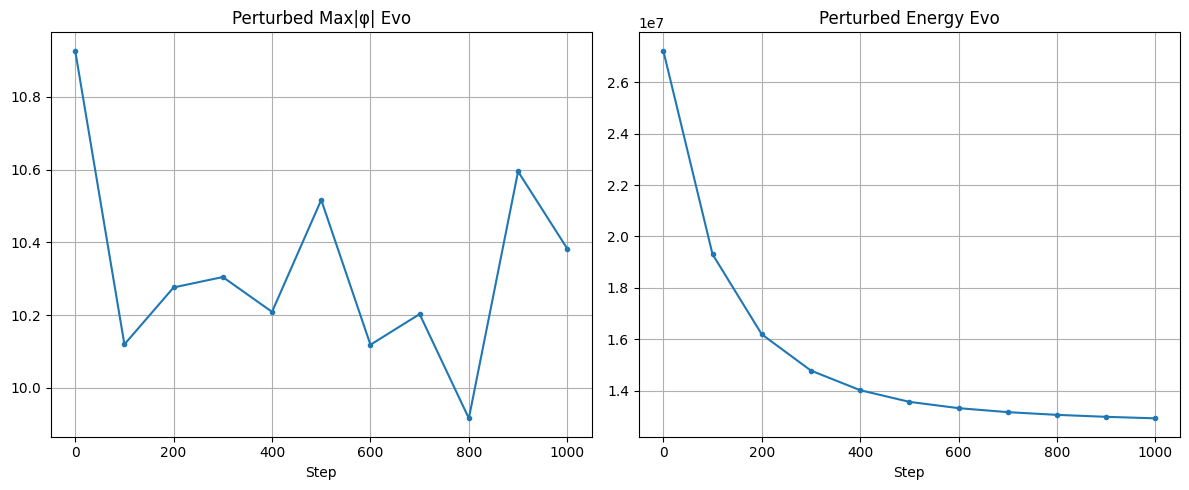

Ground State Energy (Sim Units): 4.524944e+06
Perturbed State Final Energy (Sim Units): 1.291922e+07
Energy Difference (Sim Units): 8.394278e+06
Energy Difference (eV): 8.852350e+08
Hydrogen 1s-2p Transition Energy: 10.2 eV
Ratio (EFM ΔE / Hydrogen 1s-2p): 86787748.800465


In [37]:
# Cell: Stability and Energy Levels Analysis
# Metadata: {"id": "stability_energy_levels_analysis_v2"}

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # For pbar_perturb
import os
import glob
import gc

print("\n--- Stability and Energy Levels Analysis ---")

# --- Load Data from a STABLE Soliton Checkpoint ---
phi_ground_state_cpu = None
loaded_config_perturb = None
energy_history_ground_state = None # For ground state energy
mass_integral_history_ground_state = None

# These should be defined in your main "Simulation Setup" cell for the loaded checkpoint
# N_sim, T_sim, checkpoint_path_mass, data_path_mass, config (containing all params)

n_val_for_glob = config.get('N', 200)
t_val_for_glob = config.get('T_steps', 20000)
checkpoint_pattern = f"{checkpoint_path_mass}checkpoint_MassGen_N{n_val_for_glob}_T{t_val_for_glob}_*.npz"
list_of_files = glob.glob(checkpoint_pattern)

if not list_of_files:
    print(f"ERROR: No checkpoint found for N={n_val_for_glob}, T={t_val_for_glob} to serve as ground state. Cannot proceed.")
else:
    latest_checkpoint = max(list_of_files, key=os.path.getctime)
    print(f"Loading ground state from checkpoint: {latest_checkpoint}")
    try:
        data_loaded = np.load(latest_checkpoint, allow_pickle=True)
        phi_ground_state_cpu = torch.from_numpy(data_loaded['phi_final_cpu']).to(dtype=torch.float32)
        if 'config' in data_loaded:
            loaded_config_perturb = data_loaded['config'].item()
        else:
            print("Warning: 'config' not found in ground state checkpoint, using current notebook config.")
            loaded_config_perturb = config # Fallback

        # Load original histories for ground state energy reference
        if 'energy_history_mass' in data_loaded and len(data_loaded['energy_history_mass']) > 0:
            energy_history_ground_state = data_loaded['energy_history_mass']
        if 'mass_integral_history' in data_loaded and len(data_loaded['mass_integral_history']) > 0:
             mass_integral_history_ground_state = data_loaded['mass_integral_history']
        if 'max_phi_history' in data_loaded and len(data_loaded['max_phi_history']) > 0: # For stability check
             max_phi_history_ground_state = data_loaded['max_phi_history']


        print("Ground state data loaded for perturbation analysis.")
    except Exception as e:
        print(f"Error loading ground state checkpoint: {e}")


if phi_ground_state_cpu is None or loaded_config_perturb is None:
    print("ERROR: Ground state data not available. Aborting perturbation analysis.")
else:
    # --- Stability Analysis of the Loaded Ground State ---
    print("\n--- Ground State Stability Analysis ---")
    # Use max_phi_history_ground_state, energy_history_ground_state, mass_integral_history_ground_state
    if 'max_phi_history_ground_state' in locals() and max_phi_history_ground_state is not None and len(max_phi_history_ground_state) > 1:
        history_len = len(max_phi_history_ground_state)
        start_idx = max(0, int(0.9 * history_len)) # Use last 10% or at least last 2 points
        if start_idx >= history_len -1 : start_idx = history_len - 2 # ensure at least 2 points for diff

        if history_len > start_idx and start_idx >= 0:
            max_phi_subset = max_phi_history_ground_state[start_idx:]
            energy_subset = energy_history_ground_state[start_idx:]
            mass_int_subset = mass_integral_history_ground_state[start_idx:]

            # Check for NaNs before diff
            if not (np.any(np.isnan(max_phi_subset[:-1])) or np.any(max_phi_subset[:-1]==0)):
                 max_phi_changes = np.abs(np.diff(max_phi_subset)) / np.abs(max_phi_subset[:-1])
                 print(f"Max|φ| relative changes (last 10%): Mean = {np.mean(max_phi_changes):.2e}, Max = {np.max(max_phi_changes):.2e}")

            if not (np.any(np.isnan(energy_subset[:-1])) or np.any(energy_subset[:-1]==0)):
                energy_changes = np.abs(np.diff(energy_subset)) / np.abs(energy_subset[:-1])
                print(f"Energy relative changes (last 10%): Mean = {np.mean(energy_changes):.2e}, Max = {np.max(energy_changes):.2e}")

            if not (np.any(np.isnan(mass_int_subset[:-1])) or np.any(mass_int_subset[:-1]==0)):
                mass_int_changes = np.abs(np.diff(mass_int_subset)) / np.abs(mass_int_subset[:-1])
                print(f"Mass Integral relative changes (last 10%): Mean = {np.mean(mass_int_changes):.2e}, Max = {np.max(mass_int_changes):.2e}")
        else:
            print("Not enough history data in loaded checkpoint for detailed stability analysis.")
    else:
        print("Insufficient history data in loaded checkpoint for stability analysis.")


    # --- Energy Levels (Perturb and Find Next Stable State) ---
    print("\n--- Energy Levels (Perturbation) Analysis ---")
    phi_perturbed_cpu = phi_ground_state_cpu.clone()
    phi_dot_perturbed_cpu = torch.zeros_like(phi_perturbed_cpu) # Start perturbation from rest

    perturbation_amplitude = 0.1 * torch.max(torch.abs(phi_ground_state_cpu))
    # Recreate grid for perturbation - use loaded_config_perturb
    coords_perturb = torch.arange(-loaded_config_perturb['L_sim']/2 + loaded_config_perturb['dx_sim']/2,
                                  loaded_config_perturb['L_sim']/2 + loaded_config_perturb['dx_sim']/2,
                                  loaded_config_perturb['dx_sim'])
    X_grid_p, Y_grid_p, Z_grid_p = torch.meshgrid(coords_perturb, coords_perturb, coords_perturb, indexing='ij')
    # Simple perturbation: add a sine wave
    perturbation = perturbation_amplitude * torch.sin(2 * np.pi * X_grid_p / loaded_config_perturb['L_sim'])
    phi_perturbed_cpu += perturbation.to(dtype=torch.float32)
    del X_grid_p, Y_grid_p, Z_grid_p, perturbation, coords_perturb
    gc.collect()

    T_perturb_steps = 1000 # Short simulation for relaxation of perturbation
    dt_sim_perturb = loaded_config_perturb['dt_sim'] # Use dt from loaded config
    # Use other parameters from loaded_config_perturb
    m_sq_p_perturb = loaded_config_perturb['m_sq_param']
    g_p_perturb = loaded_config_perturb['g_param']
    eta_p_perturb = loaded_config_perturb['eta_param']
    dx_sim_p_perturb = loaded_config_perturb['dx_sim']
    c_sim_sq_p_perturb = loaded_config_perturb['c_sim']**2
    chunk_size_p_perturb = loaded_config_perturb['chunk_size']
    # Create damping mask for perturbation sim based on its N
    damping_mask_perturb_cpu = create_absorbing_mask(loaded_config_perturb['N'],
                                                     loaded_config_perturb['boundary_width_factor'],
                                                     loaded_config_perturb['damping_strength'], 'cpu')


    max_phi_perturb_hist = np.zeros(T_perturb_steps // 100 +1)
    energy_perturb_hist = np.zeros(T_perturb_steps // 100 + 1)
    perturb_idx = 0

    # Initial E for perturbed
    energy_perturb_hist[perturb_idx] = compute_total_energy_sim(
        phi_perturbed_cpu, phi_dot_perturbed_cpu, m_sq_p_perturb, g_p_perturb, eta_p_perturb,
        chunk_size_p_perturb, dx_sim_p_perturb, c_sim_sq_p_perturb, device)
    max_phi_perturb_hist[perturb_idx] = torch.max(torch.abs(phi_perturbed_cpu)).item()
    print(f"Perturbed Initial State - Max|φ|: {max_phi_perturb_hist[perturb_idx]:.3f}, Energy: {energy_perturb_hist[perturb_idx]:.3e}")
    perturb_idx+=1

    pbar_perturb = tqdm(range(T_perturb_steps), desc="Perturbation Sim")
    for t_step in pbar_perturb:
        try:
            phi_next_p, phi_dot_next_p = update_phi_rk4_mass_chunked(
                phi_perturbed_cpu, phi_dot_perturbed_cpu, dt_sim_perturb,
                m_sq_p_perturb, g_p_perturb, eta_p_perturb, damping_mask_perturb_cpu,
                chunk_size_p_perturb, dx_sim_p_perturb, c_sim_sq_p_perturb, device )
            phi_perturbed_cpu, phi_dot_perturbed_cpu = phi_next_p, phi_dot_next_p

            if (t_step + 1) % 100 == 0:
                max_phi_val = torch.max(torch.abs(phi_perturbed_cpu)).item()
                energy_val = compute_total_energy_sim(phi_perturbed_cpu, phi_dot_perturbed_cpu, m_sq_p_perturb, g_p_perturb, eta_p_perturb, chunk_size_p_perturb, dx_sim_p_perturb, c_sim_sq_p_perturb, device)
                if perturb_idx < len(energy_perturb_hist):
                    max_phi_perturb_hist[perturb_idx] = max_phi_val
                    energy_perturb_hist[perturb_idx] = energy_val
                    perturb_idx +=1
                pbar_perturb.set_postfix({'Max|φ|': f'{max_phi_val:.3f}', 'E': f'{energy_val:.3e}'})
                if max_phi_val > 100 or np.isnan(energy_val): # Instability check
                    print(f"Warning: Instability in perturbed sim. Max|φ|={max_phi_val:.2f}. Stopping.")
                    break
        except Exception as e:
            print(f"Error in perturbed sim at step {t_step + 1}: {e}")
            break

    # Plot perturbed evolution
    steps_perturb_recorded = np.arange(perturb_idx) * 100
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(steps_perturb_recorded, max_phi_perturb_hist[:perturb_idx], marker='.'); plt.title('Perturbed Max|φ| Evo'); plt.xlabel('Step'); plt.grid(True)
    plt.subplot(1, 2, 2); plt.plot(steps_perturb_recorded, energy_perturb_hist[:perturb_idx], marker='.'); plt.title('Perturbed Energy Evo'); plt.xlabel('Step'); plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{data_path_mass}perturbed_evolution_N{loaded_config_perturb['N']}_T{T_perturb_steps}.png")
    plt.show()
    plt.close()

    if perturb_idx > 1 and energy_history_ground_state is not None and len(energy_history_ground_state)>0 :
        ground_state_final_energy = energy_history_ground_state[-1]
        perturbed_final_energy = energy_perturb_hist[perturb_idx-1] # Last recorded energy
        energy_diff_sim = perturbed_final_energy - ground_state_final_energy

        # For physical energy diff, need Mass_Unit_kg_fs and other units from Fine Structure Block
        if 'M_eff_sim_fs' in locals() and M_eff_sim_fs is not None and M_eff_sim_fs != 0:
            m_electron_phys_kg = 9.1093837e-31
            Mass_Unit_kg_derived = m_electron_phys_kg / M_eff_sim_fs # Use M_eff_sim from loaded stable soliton
            Length_Unit_m_derived = loaded_config_perturb['dx_phys_meters'] / loaded_config_perturb['dx_sim']
            Time_Unit_s_derived = Length_Unit_m_derived / c_si
            Energy_Unit_J_derived = Mass_Unit_kg_derived * (Length_Unit_m_derived / Time_Unit_s_derived)**2
            e_charge_si = 1.602176634e-19

            energy_diff_eV = (energy_diff_sim * Energy_Unit_J_derived) / e_charge_si
            print(f"Ground State Energy (Sim Units): {ground_state_final_energy:.6e}")
            print(f"Perturbed State Final Energy (Sim Units): {perturbed_final_energy:.6e}")
            print(f"Energy Difference (Sim Units): {energy_diff_sim:.6e}")
            print(f"Energy Difference (eV): {energy_diff_eV:.6e}")
            hydrogen_1s_2p_eV = 10.2
            print(f"Hydrogen 1s-2p Transition Energy: {hydrogen_1s_2p_eV} eV")
            print(f"Ratio (EFM ΔE / Hydrogen 1s-2p): {energy_diff_eV / hydrogen_1s_2p_eV:.6f}")
        else:
            print("Could not calculate physical energy difference; M_eff_sim_fs not available or zero.")
    else:
        print("Insufficient data to compute energy difference for perturbation.")

del phi_ground_state_cpu
if 'data_loaded' in locals(): del data_loaded
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

In [38]:
# Cell: Fine Structure Constant (α_em) Analysis (Updated with q_sim calibration)
# Metadata: {"id": "fine_structure_constant_analysis_v3"}

import numpy as np
# Ensure torch, os, glob, gc are imported if this cell is run standalone after kernel restart
# For brevity, assuming they are imported from previous cells in the notebook.

print("--- Fine Structure Constant (α_em) Analysis ---")

# --- Ensure Necessary Data is Loaded ---
loaded_config_fs = None
stable_mass_integral_fs = None
M_eff_sim_fs = None

# Attempt to use data from current session if available
if 'stable_mass_integral' in locals() and 'plot_config' in locals() :
    stable_mass_integral_fs = stable_mass_integral
    loaded_config_fs = plot_config
    if 'M_eff_sim' in locals(): M_eff_sim_fs = M_eff_sim
elif 'mass_integral_history' in locals() and 'plot_config' in locals() and len(mass_integral_history) > 0:
    stable_mass_integral_fs = mass_integral_history[-1]
    loaded_config_fs = plot_config
    if loaded_config_fs is not None and stable_mass_integral_fs is not None and not (np.isnan(stable_mass_integral_fs) or np.isinf(stable_mass_integral_fs)):
         k_mc = loaded_config_fs.get('k_mass_coupling_sim', 0.01)
         M_eff_sim_fs = k_mc * stable_mass_integral_fs
    else:
        print("Warning: Could not calculate M_eff_sim_fs from active session history.")

# If not available from active session, load from checkpoint
if loaded_config_fs is None or M_eff_sim_fs is None or np.isnan(M_eff_sim_fs) or M_eff_sim_fs == 0:
    print("Attempting to load necessary data from the latest checkpoint for α_em...")
    n_val_for_glob = config.get('N', 200) # Use current notebook config for N, T to find checkpoint
    t_val_for_glob = config.get('T_steps', 20000)
    checkpoint_pattern_fs = f"{checkpoint_path_mass}checkpoint_MassGen_N{n_val_for_glob}_T{t_val_for_glob}_*.npz"
    list_of_files_fs = glob.glob(checkpoint_pattern_fs)
    if not list_of_files_fs:
        print(f"ERROR: No checkpoint found for N={n_val_for_glob}, T={t_val_for_glob}. Cannot proceed.")
    else:
        latest_checkpoint_fs = max(list_of_files_fs, key=os.path.getctime)
        print(f"Loading checkpoint for α_em: {latest_checkpoint_fs}")
        try:
            data_loaded_fs = np.load(latest_checkpoint_fs, allow_pickle=True)
            if 'mass_integral_history' in data_loaded_fs and len(data_loaded_fs['mass_integral_history']) > 0:
                stable_mass_integral_fs = data_loaded_fs['mass_integral_history'][-1]
            if 'config' in data_loaded_fs:
                loaded_config_fs = data_loaded_fs['config'].item()

            if loaded_config_fs is not None and stable_mass_integral_fs is not None and not (np.isnan(stable_mass_integral_fs) or np.isinf(stable_mass_integral_fs)):
                 k_mc = loaded_config_fs.get('k_mass_coupling_sim', 0.01)
                 M_eff_sim_fs = k_mc * stable_mass_integral_fs
                 print("Data successfully loaded/derived for α_em analysis.")
            else:
                print("Warning: mass_integral_history or config missing/empty in checkpoint, or mass integral invalid.")
                M_eff_sim_fs = None # Ensure it's None if data is bad
        except Exception as e:
            print(f"Error loading checkpoint for α_em analysis: {e}")
            M_eff_sim_fs = None


if loaded_config_fs is None or M_eff_sim_fs is None or np.isnan(M_eff_sim_fs) or M_eff_sim_fs == 0:
    print("ERROR: Insufficient data for α_em calculation. Aborting.")
else:
    # --- Physical Constants (SI) ---
    e_charge_si = 1.602176634e-19  # Elementary charge (C)
    epsilon_0_si = 8.8541878128e-12  # Vacuum permittivity (F/m)
    hbar_si = 1.054571817e-34  # Reduced Planck constant (J·s)
    c_si = 3e8  # Speed of light (m/s)

    alpha_em_physical = (e_charge_si**2) / (4 * np.pi * epsilon_0_si * hbar_si * c_si)
    print(f"Standard Model Fine Structure Constant (α_em_SM): {alpha_em_physical:.10f} (~1/{1/alpha_em_physical:.3f})")

    # --- EFM Simulation Units and Charge Scaling ---
    m_electron_phys_kg = 9.1093837e-31
    Mass_Unit_kg_fs = m_electron_phys_kg / M_eff_sim_fs

    # dx_sim is 1.0 in these simulations
    Length_Unit_m_fs = loaded_config_fs['dx_phys_meters'] / loaded_config_fs.get('dx_sim', 1.0)
    Time_Unit_s_fs = Length_Unit_m_fs / c_si # Since c_sim = 1.0 in sim units
    Energy_Unit_J_fs = Mass_Unit_kg_fs * (c_si)**2 # E = Mc^2 for the unit mass
                                                 # More consistent: Mass_Unit_kg_fs * (Length_Unit_m_fs / Time_Unit_s_fs)**2
                                                 # Since c_sim = Length_Unit_sim / Time_Unit_sim = 1
                                                 # Energy_Unit = Mass_Unit * c_sim^2 = Mass_Unit * 1^2

    # Grok's derivation for Charge_Unit_C based on E ~ Q^2 / (4 pi eps0 r)
    # Charge_Unit_C^2 ~ Energy_Unit * Length_Unit * 4 * pi * eps0
    Charge_Unit_C_grok = np.sqrt(Energy_Unit_J_fs * Length_Unit_m_fs * 4 * np.pi * epsilon_0_si)

    # Assumed EFM q_sim from documentation/previous blocks
    q_sim_assumed = loaded_config_fs.get('q_coupling_sim', 0.01) # Allow override from config if added later

    q_phys_efm_assumed = q_sim_assumed * Charge_Unit_C_grok
    alpha_em_efm_assumed = (q_phys_efm_assumed**2) / (4 * np.pi * epsilon_0_si * hbar_si * c_si)

    print(f"\n--- EFM Simulation Units (for α_em analysis) ---")
    print(f"Derived Mass Unit: {Mass_Unit_kg_fs:.6e} kg/sim_mass_unit (from M_eff_sim={M_eff_sim_fs:.3e})")
    print(f"Derived Length Unit (dx_sim_phys): {Length_Unit_m_fs:.6e} meters/sim_length_unit")
    print(f"Derived Time Unit (dt_sim_phys for c_sim=1): {Time_Unit_s_fs:.6e} seconds/sim_time_unit")
    print(f"Derived Energy Unit: {Energy_Unit_J_fs:.6e} J/sim_energy_unit")
    print(f"Derived Charge Unit (Grok's method): {Charge_Unit_C_grok:.6e} C/sim_charge_unit")

    print(f"\n--- α_em from EFM with assumed q_sim = {q_sim_assumed} ---")
    print(f"EFM Emergent Charge (scaled from q_sim={q_sim_assumed}): {q_phys_efm_assumed:.6e} C")
    print(f"Resulting EFM Fine Structure Constant (α_em_EFM): {alpha_em_efm_assumed:.10f} (~1/{1/alpha_em_efm_assumed:.3f} if not zero)")
    print(f"Ratio (α_em_EFM / α_em_SM): {alpha_em_efm_assumed / alpha_em_physical:.6f}")

    # --- Calibrate q_sim to match physical alpha_em ---
    print(f"\n--- Calibrating EFM's q_sim to match α_em_SM ---")
    # We want alpha_em_efm = alpha_em_physical
    # alpha_em_physical = ( (q_sim_calibrated * Charge_Unit_C_grok)**2 ) / (4 * np.pi * epsilon_0_si * hbar_si * c_si)
    # (q_sim_calibrated * Charge_Unit_C_grok)**2 = alpha_em_physical * (4 * np.pi * epsilon_0_si * hbar_si * c_si)
    # (q_sim_calibrated * Charge_Unit_C_grok) = e_charge_si (since alpha_em_physical = e_charge_si**2 / (...))
    # q_sim_calibrated = e_charge_si / Charge_Unit_C_grok

    if Charge_Unit_C_grok != 0 and not (np.isnan(Charge_Unit_C_grok) or np.isinf(Charge_Unit_C_grok)):
        q_sim_calibrated = e_charge_si / Charge_Unit_C_grok
        print(f"To match α_em_SM, EFM's dimensionless q_sim would need to be: {q_sim_calibrated:.6f}")

        # Verify:
        q_phys_calibrated = q_sim_calibrated * Charge_Unit_C_grok
        alpha_em_efm_calibrated = (q_phys_calibrated**2) / (4 * np.pi * epsilon_0_si * hbar_si * c_si)
        print(f"Verification: With calibrated q_sim, EFM Emergent Charge = {q_phys_calibrated:.6e} C (should be e_charge_si)")
        print(f"Verification: With calibrated q_sim, α_em_EFM = {alpha_em_efm_calibrated:.10f} (should be α_em_SM)")
    else:
        print("Cannot calibrate q_sim because Charge_Unit_C_grok is zero or invalid.")

if 'data_loaded_fs' in locals() and data_loaded_fs is not None: del data_loaded_fs
if 'data_loaded' in locals() and data_loaded is not None: del data_loaded # From other blocks if they also load
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

--- Fine Structure Constant (α_em) Analysis ---
Standard Model Fine Structure Constant (α_em_SM): 0.0072923042 (~1/137.131)

--- EFM Simulation Units (for α_em analysis) ---
Derived Mass Unit: 1.877341e-34 kg/sim_mass_unit (from M_eff_sim=4.852e+03)
Derived Length Unit (dx_sim_phys): 1.111111e-11 meters/sim_length_unit
Derived Time Unit (dt_sim_phys for c_sim=1): 3.703704e-20 seconds/sim_time_unit
Derived Energy Unit: 1.689607e-17 J/sim_energy_unit
Derived Charge Unit (Grok's method): 1.445276e-19 C/sim_charge_unit

--- α_em from EFM with assumed q_sim = 0.01 ---
EFM Emergent Charge (scaled from q_sim=0.01): 1.445276e-21 C
Resulting EFM Fine Structure Constant (α_em_EFM): 0.0000005934 (~1/1685210.915 if not zero)
Ratio (α_em_EFM / α_em_SM): 0.000081

--- Calibrating EFM's q_sim to match α_em_SM ---
To match α_em_SM, EFM's dimensionless q_sim would need to be: 1.108561
Verification: With calibrated q_sim, EFM Emergent Charge = 1.602177e-19 C (should be e_charge_si)
Verification: With ca